In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [3]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [4]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
  
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)       
        
    return (data)

In [10]:
df = preprocess(data)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0, stratify = df.Stage)

In [69]:
outliers = x_train[( (x_train.Has_Contract == False) & (x_train.Stage == 1) ) | ( (x_train.Has_Contract == True) & (x_train.Stage == 0) )]        

In [70]:
from sklearn.utils import resample

In [81]:
RESAMPLE = 3000
upsample = resample(outliers, replace = True, n_samples = RESAMPLE, random_state = 1233423)

In [82]:
x_train = pd.concat([x_train, upsample])

In [83]:
categorical = [x for x in dfef.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.739708
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.731256
[3]	valid_0's binary_logloss: 0.720891
[4]	valid_0's binary_logloss: 0.713127
[5]	valid_0's binary_logloss: 0.705123
[6]	valid_0's binary_logloss: 0.699996
[7]	valid_0's binary_logloss: 0.692158
[8]	valid_0's binary_logloss: 0.68558
[9]	valid_0's binary_logloss: 0.678812
[10]	valid_0's binary_logloss: 0.670261
[11]	valid_0's binary_logloss: 0.663811
[12]	valid_0's binary_logloss: 0.655954
[13]	valid_0's binary_logloss: 0.649828
[14]	valid_0's binary_logloss: 0.64367
[15]	valid_0's binary_logloss: 0.636962
[16]	valid_0's binary_logloss: 0.628936
[17]	valid_0's binary_logloss: 0.623186
[18]	valid_0's binary_logloss: 0.615516
[19]	valid_0's binary_logloss: 0.610865
[20]	valid_0's binary_logloss: 0.605769
[21]	valid_0's binary_logloss: 0.598173
[22]	valid_0's binary_logloss: 0.593397
[23]	valid_0's binary_logloss: 0.585992
[24]	valid_0's binary_logloss

[212]	valid_0's binary_logloss: 0.194914
[213]	valid_0's binary_logloss: 0.194556
[214]	valid_0's binary_logloss: 0.193253
[215]	valid_0's binary_logloss: 0.192909
[216]	valid_0's binary_logloss: 0.192677
[217]	valid_0's binary_logloss: 0.191261
[218]	valid_0's binary_logloss: 0.190921
[219]	valid_0's binary_logloss: 0.190666
[220]	valid_0's binary_logloss: 0.189431
[221]	valid_0's binary_logloss: 0.188207
[222]	valid_0's binary_logloss: 0.18794
[223]	valid_0's binary_logloss: 0.186696
[224]	valid_0's binary_logloss: 0.185399
[225]	valid_0's binary_logloss: 0.1842
[226]	valid_0's binary_logloss: 0.183791
[227]	valid_0's binary_logloss: 0.182606
[228]	valid_0's binary_logloss: 0.181382
[229]	valid_0's binary_logloss: 0.181079
[230]	valid_0's binary_logloss: 0.180765
[231]	valid_0's binary_logloss: 0.180417
[232]	valid_0's binary_logloss: 0.179226
[233]	valid_0's binary_logloss: 0.17894
[234]	valid_0's binary_logloss: 0.177776
[235]	valid_0's binary_logloss: 0.177524
[236]	valid_0's bina

[424]	valid_0's binary_logloss: 0.10216
[425]	valid_0's binary_logloss: 0.102099
[426]	valid_0's binary_logloss: 0.101996
[427]	valid_0's binary_logloss: 0.101907
[428]	valid_0's binary_logloss: 0.101813
[429]	valid_0's binary_logloss: 0.101757
[430]	valid_0's binary_logloss: 0.10167
[431]	valid_0's binary_logloss: 0.101285
[432]	valid_0's binary_logloss: 0.101197
[433]	valid_0's binary_logloss: 0.101081
[434]	valid_0's binary_logloss: 0.100664
[435]	valid_0's binary_logloss: 0.100587
[436]	valid_0's binary_logloss: 0.100574
[437]	valid_0's binary_logloss: 0.100165
[438]	valid_0's binary_logloss: 0.099724
[439]	valid_0's binary_logloss: 0.0996271
[440]	valid_0's binary_logloss: 0.0992253
[441]	valid_0's binary_logloss: 0.0988315
[442]	valid_0's binary_logloss: 0.0987417
[443]	valid_0's binary_logloss: 0.0983903
[444]	valid_0's binary_logloss: 0.0982779
[445]	valid_0's binary_logloss: 0.0982204
[446]	valid_0's binary_logloss: 0.0978718
[447]	valid_0's binary_logloss: 0.0978278
[448]	val

[636]	valid_0's binary_logloss: 0.0753207
[637]	valid_0's binary_logloss: 0.0752028
[638]	valid_0's binary_logloss: 0.0751905
[639]	valid_0's binary_logloss: 0.0751769
[640]	valid_0's binary_logloss: 0.0750347
[641]	valid_0's binary_logloss: 0.0749072
[642]	valid_0's binary_logloss: 0.074719
[643]	valid_0's binary_logloss: 0.0745322
[644]	valid_0's binary_logloss: 0.0743797
[645]	valid_0's binary_logloss: 0.0743888
[646]	valid_0's binary_logloss: 0.0743027
[647]	valid_0's binary_logloss: 0.0742768
[648]	valid_0's binary_logloss: 0.0742512
[649]	valid_0's binary_logloss: 0.0740741
[650]	valid_0's binary_logloss: 0.0740672
[651]	valid_0's binary_logloss: 0.0739368
[652]	valid_0's binary_logloss: 0.0738472
[653]	valid_0's binary_logloss: 0.0738215
[654]	valid_0's binary_logloss: 0.0737387
[655]	valid_0's binary_logloss: 0.0736168
[656]	valid_0's binary_logloss: 0.0734476
[657]	valid_0's binary_logloss: 0.0734307
[658]	valid_0's binary_logloss: 0.0734041
[659]	valid_0's binary_logloss: 0.0

[840]	valid_0's binary_logloss: 0.0657911
[841]	valid_0's binary_logloss: 0.0657972
[842]	valid_0's binary_logloss: 0.0658357
[843]	valid_0's binary_logloss: 0.0658567
[844]	valid_0's binary_logloss: 0.0658056
[845]	valid_0's binary_logloss: 0.0657344
[846]	valid_0's binary_logloss: 0.0657494
[847]	valid_0's binary_logloss: 0.0657518
[848]	valid_0's binary_logloss: 0.065748
[849]	valid_0's binary_logloss: 0.0657733
[850]	valid_0's binary_logloss: 0.0657651
[851]	valid_0's binary_logloss: 0.0657863
[852]	valid_0's binary_logloss: 0.06574
[853]	valid_0's binary_logloss: 0.0656969
[854]	valid_0's binary_logloss: 0.0656985
[855]	valid_0's binary_logloss: 0.0656876
[856]	valid_0's binary_logloss: 0.065642
[857]	valid_0's binary_logloss: 0.0655788
[858]	valid_0's binary_logloss: 0.065596
[859]	valid_0's binary_logloss: 0.0655621
[860]	valid_0's binary_logloss: 0.0655363
[861]	valid_0's binary_logloss: 0.0655445
[862]	valid_0's binary_logloss: 0.0655155
[863]	valid_0's binary_logloss: 0.06552

[1048]	valid_0's binary_logloss: 0.0637596
[1049]	valid_0's binary_logloss: 0.0637678
[1050]	valid_0's binary_logloss: 0.0637292
[1051]	valid_0's binary_logloss: 0.0637323
[1052]	valid_0's binary_logloss: 0.0637214
[1053]	valid_0's binary_logloss: 0.0637269
[1054]	valid_0's binary_logloss: 0.0637135
[1055]	valid_0's binary_logloss: 0.0636986
[1056]	valid_0's binary_logloss: 0.063718
[1057]	valid_0's binary_logloss: 0.0636595
[1058]	valid_0's binary_logloss: 0.0636732
[1059]	valid_0's binary_logloss: 0.0636895
[1060]	valid_0's binary_logloss: 0.0636844
[1061]	valid_0's binary_logloss: 0.0636618
[1062]	valid_0's binary_logloss: 0.0636813
[1063]	valid_0's binary_logloss: 0.0636635
[1064]	valid_0's binary_logloss: 0.0636818
[1065]	valid_0's binary_logloss: 0.0636932
[1066]	valid_0's binary_logloss: 0.063699
[1067]	valid_0's binary_logloss: 0.0636922
[1068]	valid_0's binary_logloss: 0.0636794
[1069]	valid_0's binary_logloss: 0.0637078
[1070]	valid_0's binary_logloss: 0.0637253
[1071]	valid_

[1255]	valid_0's binary_logloss: 0.0649094
[1256]	valid_0's binary_logloss: 0.0649115
[1257]	valid_0's binary_logloss: 0.0649286
[1258]	valid_0's binary_logloss: 0.0649684
[1259]	valid_0's binary_logloss: 0.0649646
[1260]	valid_0's binary_logloss: 0.064978
[1261]	valid_0's binary_logloss: 0.0650002
[1262]	valid_0's binary_logloss: 0.0649807
[1263]	valid_0's binary_logloss: 0.0649844
[1264]	valid_0's binary_logloss: 0.0650176
[1265]	valid_0's binary_logloss: 0.0650258
[1266]	valid_0's binary_logloss: 0.065022
[1267]	valid_0's binary_logloss: 0.0650428
[1268]	valid_0's binary_logloss: 0.0650498
[1269]	valid_0's binary_logloss: 0.0650632
[1270]	valid_0's binary_logloss: 0.0650898
[1271]	valid_0's binary_logloss: 0.0651099
[1272]	valid_0's binary_logloss: 0.0651529
[1273]	valid_0's binary_logloss: 0.065133
[1274]	valid_0's binary_logloss: 0.0651469
[1275]	valid_0's binary_logloss: 0.0651589
[1276]	valid_0's binary_logloss: 0.0651684
[1277]	valid_0's binary_logloss: 0.0651944
[1278]	valid_0

[1449]	valid_0's binary_logloss: 0.0672849
[1450]	valid_0's binary_logloss: 0.0672839
[1451]	valid_0's binary_logloss: 0.06729
[1452]	valid_0's binary_logloss: 0.0673295
[1453]	valid_0's binary_logloss: 0.0673502
[1454]	valid_0's binary_logloss: 0.0673727
[1455]	valid_0's binary_logloss: 0.0674206
[1456]	valid_0's binary_logloss: 0.0674324
[1457]	valid_0's binary_logloss: 0.0674835
[1458]	valid_0's binary_logloss: 0.0675116
[1459]	valid_0's binary_logloss: 0.0675415
[1460]	valid_0's binary_logloss: 0.0675681
[1461]	valid_0's binary_logloss: 0.0675823
[1462]	valid_0's binary_logloss: 0.0676193
[1463]	valid_0's binary_logloss: 0.0676388
[1464]	valid_0's binary_logloss: 0.0676698
[1465]	valid_0's binary_logloss: 0.0676605
[1466]	valid_0's binary_logloss: 0.0676755
[1467]	valid_0's binary_logloss: 0.0676726
[1468]	valid_0's binary_logloss: 0.0676724
[1469]	valid_0's binary_logloss: 0.0677002
[1470]	valid_0's binary_logloss: 0.0676901
[1471]	valid_0's binary_logloss: 0.067715
[1472]	valid_0

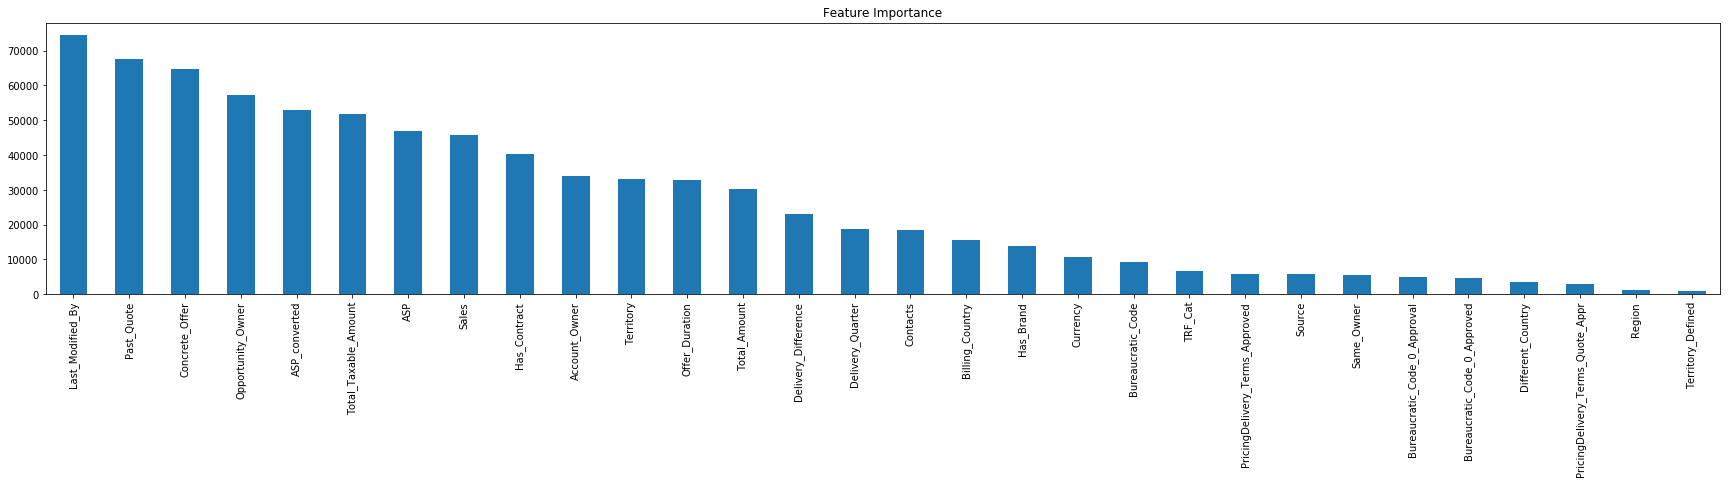

In [84]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [85]:
y_pred = model.predict(x_test.drop(target, axis = 1))
pred = pd.DataFrame(y_pred, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
x_test_pred["Max_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("max")
x_test_pred["Min_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("min")
x_test_pred["Mean_pred"] = x_test_pred.groupby("Opportunity_ID", sort = False)["Prediction"].transform("mean")
#answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction", "Max_pred", "Min_pred", "Mean_pred"].mean()

In [86]:
x_test_pred.loc[ (x_test_pred.Contacts > 1) & ( ((x_test_pred.Has_Contract == True) & (x_test_pred.Stage == 0)) | ( (x_test_pred.Has_Contract == False) & (x_test_pred.Stage == 1) ) ), ["Opportunity_ID", "Prediction", "Max_pred", "Min_pred", "Mean_pred", "Stage", "Has_Contract"]].sort_values(by = "Opportunity_ID")

,Opportunity_ID,Prediction,Max_pred,Min_pred,Mean_pred,Stage,Has_Contract
72,27,0.999161,0.999161,0.999161,0.999161,1,False
76,28,0.999402,0.999402,0.999402,0.999402,1,False
79,31,0.996360,0.996360,0.996360,0.996360,1,False
638,292,0.670236,0.670236,0.015727,0.342981,0,True
639,292,0.015727,0.670236,0.015727,0.342981,0,True
2607,1451,0.027211,0.027211,0.027211,0.027211,0,True
4840,2874,0.038962,0.065516,0.038962,0.048142,0,True
4839,2874,0.065516,0.065516,0.038962,0.048142,0,True
4837,2874,0.039947,0.065516,0.038962,0.048142,0,True
6127,3785,0.005781,0.005781,0.005319,0.005550,0,True


In [87]:
answer = x_test_pred.groupby("Opportunity_ID")["Opportunity_ID","Prediction", "Stage"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.0744064787858592

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0, stratify = df.Stage)

In [22]:
categorical = [x for x in df_def.drop(target, axis = 1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
train_data = lgb.Dataset(data = x_train.drop(target, axis = 1), label = x_train.Stage, categorical_feature = categorical)
test_data =  lgb.Dataset(data = x_test.drop(target, axis = 1), label = x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 50,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 30,
    'learning_rate': 0.015,
    'max_bin': 400,
    'verbose': 0
}

model2 = lgb.train(parameters, train_data, valid_sets = test_data, num_boost_round = 5000, early_stopping_rounds = 500)

[1]	valid_0's binary_logloss: 0.677077
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.669307
[3]	valid_0's binary_logloss: 0.656655
[4]	valid_0's binary_logloss: 0.649736
[5]	valid_0's binary_logloss: 0.642536
[6]	valid_0's binary_logloss: 0.637988
[7]	valid_0's binary_logloss: 0.631087
[8]	valid_0's binary_logloss: 0.624721
[9]	valid_0's binary_logloss: 0.618286
[10]	valid_0's binary_logloss: 0.607216
[11]	valid_0's binary_logloss: 0.601221
[12]	valid_0's binary_logloss: 0.590672
[13]	valid_0's binary_logloss: 0.585369
[14]	valid_0's binary_logloss: 0.579489
[15]	valid_0's binary_logloss: 0.569629
[16]	valid_0's binary_logloss: 0.559837
[17]	valid_0's binary_logloss: 0.554425
[18]	valid_0's binary_logloss: 0.545158
[19]	valid_0's binary_logloss: 0.541147
[20]	valid_0's binary_logloss: 0.536472
[21]	valid_0's binary_logloss: 0.527572
[22]	valid_0's binary_logloss: 0.523125
[23]	valid_0's binary_logloss: 0.514533
[24]	valid_0's binary_loglo

[216]	valid_0's binary_logloss: 0.135486
[217]	valid_0's binary_logloss: 0.134555
[218]	valid_0's binary_logloss: 0.1343
[219]	valid_0's binary_logloss: 0.13407
[220]	valid_0's binary_logloss: 0.133159
[221]	valid_0's binary_logloss: 0.132249
[222]	valid_0's binary_logloss: 0.132043
[223]	valid_0's binary_logloss: 0.131174
[224]	valid_0's binary_logloss: 0.130203
[225]	valid_0's binary_logloss: 0.129414
[226]	valid_0's binary_logloss: 0.129082
[227]	valid_0's binary_logloss: 0.128279
[228]	valid_0's binary_logloss: 0.127479
[229]	valid_0's binary_logloss: 0.127289
[230]	valid_0's binary_logloss: 0.127069
[231]	valid_0's binary_logloss: 0.126903
[232]	valid_0's binary_logloss: 0.12609
[233]	valid_0's binary_logloss: 0.125917
[234]	valid_0's binary_logloss: 0.125071
[235]	valid_0's binary_logloss: 0.124869
[236]	valid_0's binary_logloss: 0.124634
[237]	valid_0's binary_logloss: 0.123864
[238]	valid_0's binary_logloss: 0.123026
[239]	valid_0's binary_logloss: 0.122809
[240]	valid_0's bina

[422]	valid_0's binary_logloss: 0.0792577
[423]	valid_0's binary_logloss: 0.0791058
[424]	valid_0's binary_logloss: 0.0789398
[425]	valid_0's binary_logloss: 0.0789179
[426]	valid_0's binary_logloss: 0.0788866
[427]	valid_0's binary_logloss: 0.078793
[428]	valid_0's binary_logloss: 0.0787584
[429]	valid_0's binary_logloss: 0.0786797
[430]	valid_0's binary_logloss: 0.0786426
[431]	valid_0's binary_logloss: 0.0784505
[432]	valid_0's binary_logloss: 0.0784031
[433]	valid_0's binary_logloss: 0.0783292
[434]	valid_0's binary_logloss: 0.0781919
[435]	valid_0's binary_logloss: 0.078138
[436]	valid_0's binary_logloss: 0.0780748
[437]	valid_0's binary_logloss: 0.0778963
[438]	valid_0's binary_logloss: 0.0777091
[439]	valid_0's binary_logloss: 0.0776369
[440]	valid_0's binary_logloss: 0.0775191
[441]	valid_0's binary_logloss: 0.0773504
[442]	valid_0's binary_logloss: 0.0772954
[443]	valid_0's binary_logloss: 0.0771492
[444]	valid_0's binary_logloss: 0.0771172
[445]	valid_0's binary_logloss: 0.07

[637]	valid_0's binary_logloss: 0.0665192
[638]	valid_0's binary_logloss: 0.0664909
[639]	valid_0's binary_logloss: 0.066479
[640]	valid_0's binary_logloss: 0.0664399
[641]	valid_0's binary_logloss: 0.0664375
[642]	valid_0's binary_logloss: 0.0664479
[643]	valid_0's binary_logloss: 0.0664207
[644]	valid_0's binary_logloss: 0.0664098
[645]	valid_0's binary_logloss: 0.0664108
[646]	valid_0's binary_logloss: 0.0664026
[647]	valid_0's binary_logloss: 0.0663806
[648]	valid_0's binary_logloss: 0.0663522
[649]	valid_0's binary_logloss: 0.0663485
[650]	valid_0's binary_logloss: 0.0663224
[651]	valid_0's binary_logloss: 0.0663006
[652]	valid_0's binary_logloss: 0.0662652
[653]	valid_0's binary_logloss: 0.0662438
[654]	valid_0's binary_logloss: 0.0662202
[655]	valid_0's binary_logloss: 0.0661974
[656]	valid_0's binary_logloss: 0.0661614
[657]	valid_0's binary_logloss: 0.0661865
[658]	valid_0's binary_logloss: 0.0661464
[659]	valid_0's binary_logloss: 0.0661358
[660]	valid_0's binary_logloss: 0.0

[860]	valid_0's binary_logloss: 0.0641949
[861]	valid_0's binary_logloss: 0.064217
[862]	valid_0's binary_logloss: 0.0642266
[863]	valid_0's binary_logloss: 0.0642385
[864]	valid_0's binary_logloss: 0.0642385
[865]	valid_0's binary_logloss: 0.0642631
[866]	valid_0's binary_logloss: 0.0642694
[867]	valid_0's binary_logloss: 0.064265
[868]	valid_0's binary_logloss: 0.0642954
[869]	valid_0's binary_logloss: 0.0643236
[870]	valid_0's binary_logloss: 0.0643511
[871]	valid_0's binary_logloss: 0.0643629
[872]	valid_0's binary_logloss: 0.064359
[873]	valid_0's binary_logloss: 0.0643082
[874]	valid_0's binary_logloss: 0.0643055
[875]	valid_0's binary_logloss: 0.0642671
[876]	valid_0's binary_logloss: 0.0642241
[877]	valid_0's binary_logloss: 0.0642512
[878]	valid_0's binary_logloss: 0.0642406
[879]	valid_0's binary_logloss: 0.0642455
[880]	valid_0's binary_logloss: 0.0642211
[881]	valid_0's binary_logloss: 0.0641626
[882]	valid_0's binary_logloss: 0.0641502
[883]	valid_0's binary_logloss: 0.064

[1061]	valid_0's binary_logloss: 0.0648873
[1062]	valid_0's binary_logloss: 0.064913
[1063]	valid_0's binary_logloss: 0.0649745
[1064]	valid_0's binary_logloss: 0.0649937
[1065]	valid_0's binary_logloss: 0.0649992
[1066]	valid_0's binary_logloss: 0.0650708
[1067]	valid_0's binary_logloss: 0.0650648
[1068]	valid_0's binary_logloss: 0.0651081
[1069]	valid_0's binary_logloss: 0.0651311
[1070]	valid_0's binary_logloss: 0.0650999
[1071]	valid_0's binary_logloss: 0.0651362
[1072]	valid_0's binary_logloss: 0.0651534
[1073]	valid_0's binary_logloss: 0.0651567
[1074]	valid_0's binary_logloss: 0.065184
[1075]	valid_0's binary_logloss: 0.0651972
[1076]	valid_0's binary_logloss: 0.0652052
[1077]	valid_0's binary_logloss: 0.0652155
[1078]	valid_0's binary_logloss: 0.0652296
[1079]	valid_0's binary_logloss: 0.0652887
[1080]	valid_0's binary_logloss: 0.0652634
[1081]	valid_0's binary_logloss: 0.0652731
[1082]	valid_0's binary_logloss: 0.0652925
[1083]	valid_0's binary_logloss: 0.0652754
[1084]	valid_

[1252]	valid_0's binary_logloss: 0.0674514
[1253]	valid_0's binary_logloss: 0.0674542
[1254]	valid_0's binary_logloss: 0.0674673
[1255]	valid_0's binary_logloss: 0.0674609
[1256]	valid_0's binary_logloss: 0.0674752
[1257]	valid_0's binary_logloss: 0.0674721
[1258]	valid_0's binary_logloss: 0.0674815
[1259]	valid_0's binary_logloss: 0.0675452
[1260]	valid_0's binary_logloss: 0.0675446
[1261]	valid_0's binary_logloss: 0.0676145
[1262]	valid_0's binary_logloss: 0.0676029
[1263]	valid_0's binary_logloss: 0.0676241
[1264]	valid_0's binary_logloss: 0.067695
[1265]	valid_0's binary_logloss: 0.0676852
[1266]	valid_0's binary_logloss: 0.0677131
[1267]	valid_0's binary_logloss: 0.0677596
[1268]	valid_0's binary_logloss: 0.0677892
[1269]	valid_0's binary_logloss: 0.0678038
[1270]	valid_0's binary_logloss: 0.0678133
[1271]	valid_0's binary_logloss: 0.067817
[1272]	valid_0's binary_logloss: 0.0678171
[1273]	valid_0's binary_logloss: 0.0678759
[1274]	valid_0's binary_logloss: 0.0678674
[1275]	valid_

In [32]:
y_pred2 = model2.predict(x_test.drop(target, axis = 1))
pred2 = pd.DataFrame(y_pred2, index = x_test.index, columns = ["Prediction"])
x_test_pred2 = x_test.join(pred2)
x_test_pred2["Max_pred"] = x_test_pred2.groupby("Opportunity_ID", sort = False)["Prediction"].transform("max")
x_test_pred2["Min_pred"] = x_test_pred2.groupby("Opportunity_ID", sort = False)["Prediction"].transform("min")
x_test_pred2["Mean_pred"] = x_test_pred2.groupby("Opportunity_ID", sort = False)["Prediction"].transform("mean")

In [65]:
check = x_test.join(pred)

In [66]:
y_pred2 = model2.predict(x_test.drop(target, axis = 1))
pred2 = pd.DataFrame(y_pred2, index = check.index, columns = ["Prediction2"])
check = check.join(pred2)

In [79]:
check.loc[ abs(check.Prediction - check.Prediction2) > 0.1, ["Opportunity_ID", "Prediction", "Prediction2", "Stage"]]

,Opportunity_ID,Prediction,Prediction2,Stage
6129,3785,0.007956,0.122158,0
7567,4670,0.320918,0.657436,1
16116,12378,0.867447,0.483983,1
5933,3649,0.552318,0.801327,1
9534,6036,0.742785,0.847276,1
12145,7393,0.025916,0.148794,0
15743,10193,0.164308,0.063531,0
6527,4041,0.529077,0.837246,0
7950,4941,0.649645,0.751544,1
11648,7119,0.029713,0.236340,0


In [80]:
check.loc[( ((check.Has_Contract == True) & (check.Stage == 0)) | ( (check.Has_Contract == False) & (check.Stage == 1) ) ), ["Opportunity_ID", "Prediction", "Prediction2", "Stage", "Has_Contract"]].sort_values(by = "Opportunity_ID")

,Opportunity_ID,Prediction,Prediction2,Stage,Has_Contract
72,27,0.998970,0.984578,1,False
76,28,0.998963,0.978637,1,False
79,31,0.995008,0.781293,1,False
139,54,0.973188,0.884873,1,False
142,57,0.989634,0.938130,1,False
184,94,0.991115,0.858759,1,False
194,103,0.999087,0.973811,1,False
374,154,0.923483,0.950018,0,True
437,195,0.996528,0.994365,0,True
639,292,0.030846,0.124708,0,True


In [53]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("acceptable/submission_11.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9825793663087223

In [57]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9829322785382894

In [58]:
answer.to_csv("submission_resample_0.csv", header = False, index = False)

In [59]:
answer

,Opportunity_ID,Prediction
0,10689,0.999427
1,10690,0.998148
2,10691,0.928080
3,10692,0.522099
4,10693,0.994658
5,10694,0.993870
6,10695,0.001592
7,10696,0.001561
8,10697,0.005241
9,10698,0.001327
